In [98]:
import sys
import os

# Get the path to the parent directory (consumption)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the parent directory to the Python path
sys.path.append(parent_dir)

# Now you can import the LSTMModel from the dnn.models module
from dnn.models import LSTMModel
from dnn.dataset import Dataset

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from setpoint_timeseries import generate_setpoint_timeseries

# Load data

### Setpoint timeseries

In [100]:
# Load the data
with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/setpoint_timeseries.pkl', 'rb') as f:
    full_setpoint_timeseries = pickle.load(f)

### Weather data

In [101]:
weather_data = pd.read_csv("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/G2500170_2018.csv")

### ResStock

In [102]:
resstock = pd.read_parquet("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/MA_baseline_metadata_and_annual_results.parquet")

### Building timeseries

In [103]:
building_data = pd.read_parquet("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/1000-0.parquet")

### Setpoint timeseries plot

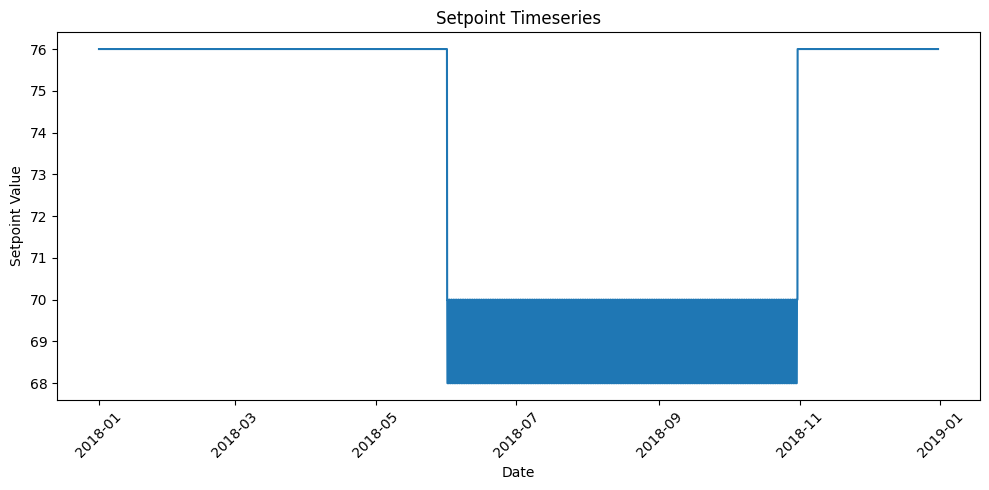

In [97]:
# Plot first timeseries
timeseries = full_setpoint_timeseries[1000]

# Plot the timeseries
plt.figure(figsize=(10, 5))
plt.plot(timeseries.index, timeseries["setpoint"])
plt.title("Setpoint Timeseries")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Transform data

In [104]:
def get_cols(building_data: pd.DataFrame, building_id: int) -> str:

    try:
        building = building_data.loc[building_id]
    except:
        raise ValueError("Building ID not found in the dataset")

    match building["in.heating_fuel"]:
        case  "Natural Gas":
            return "out.natural_gas.heating.energy_consumption"
        case "Electricity":
            return "out.electricity.heating.energy_consumption"
        case "Fuel Oil":
            return "out.fuel_oil.heating.energy_consumption"
        case "Propane":
            return "out.propane.heating.energy_consumption"
        case _:
            return "out.electricity.heating.energy_consumption"

In [105]:
# Change date time column name to timestamp
weather_data.rename(columns={'date_time': "timestamp"}, inplace=True)
weather_data.set_index('timestamp', inplace=True)
weather_data.index = pd.to_datetime(weather_data.index)

# Delete all columns except dry bulb temperature
weather_data = weather_data[["Dry Bulb Temperature [°C]"]]
weather_data.rename(columns={"Dry Bulb Temperature [°C]": "temperature"}, inplace=True)

# Create an entry for 2018-01-01 00:00:00
new_row = pd.DataFrame({'temperature': weather_data.iloc[0]['temperature']}, index=[pd.to_datetime('2018-01-01 00:00:00')])
weather_data = pd.concat([new_row, weather_data])

# Remove last 19 rows
weather_data = weather_data[:-24]

In [106]:
col_to_use = get_cols(resstock, 1000)
consumption_timeseries = building_data[["timestamp", col_to_use]]

# Resample to hourly data
consumption_timeseries["timestamp"] = pd.to_datetime(consumption_timeseries["timestamp"])
consumption_timeseries.set_index("timestamp", inplace=True)
consumption_timeseries = consumption_timeseries.resample("H").mean()
consumption_timeseries = consumption_timeseries[col_to_use]

consumption_timeseries = consumption_timeseries[:-24]

# Turn into dataframe
consumption_timeseries = pd.DataFrame(consumption_timeseries)
consumption_timeseries.rename(columns={col_to_use: "consumption"}, inplace=True)

In [107]:
exog_variables = pd.merge(
    consumption_timeseries,
    weather_data,
    left_index=True,
    right_index=True,
)

# Timeseries prediction

In [325]:
# Predict timeseries with index 1000
timeseries = full_setpoint_timeseries[1000]

train_size = 0.9
endog_train = timeseries[:int(train_size * len(timeseries))]
endog_test = timeseries[int(train_size * len(timeseries)):]

exog_train = exog_variables[:int(train_size * len(exog_variables))]
exog_test = exog_variables[int(train_size * len(exog_variables)):]

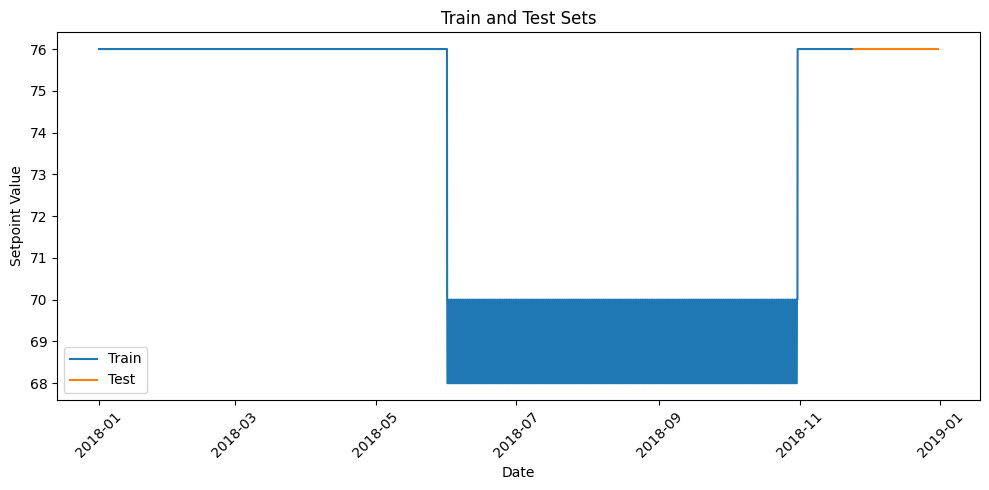

In [326]:
# Plot the training and test sets
plt.figure(figsize=(10, 5))
plt.plot(endog_train.index, endog_train["setpoint"], label="Train")
plt.plot(endog_test.index, endog_test["setpoint"], label="Test")
plt.title("Train and Test Sets")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## ARIMA

In [327]:
model = ARIMA(
    endog=endog_train,
    exog=exog_train,
    order=(1, 1, 1),
    seasonal_order=(1, 0, 1, 24),
    freq="h",
)
model_fit = model.fit()

In [328]:
print(model_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:                         setpoint   No. Observations:                 7863
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood                5452.191
Date:                          Tue, 01 Apr 2025   AIC                         -10890.383
Time:                                  13:31:22   BIC                         -10841.594
Sample:                              01-01-2018   HQIC                        -10873.669
                                   - 11-24-2018                                         
Covariance Type:                            opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
consumption     0.0024      0.071      0.035      0.972      -0.136       0.141
temperature    -0.0015      0.002     -0.731    

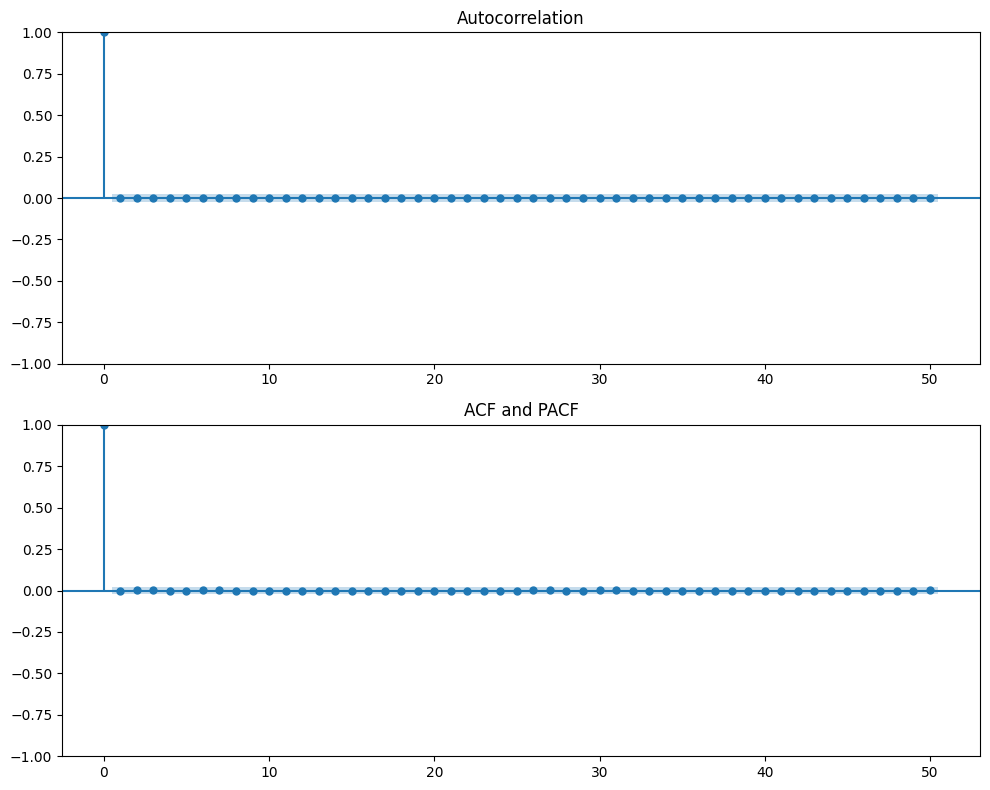

In [329]:
# Plot ACF and PACF

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(model_fit.resid, lags=50, ax=ax[0])
plot_pacf(model_fit.resid, lags=50, ax=ax[1])
plt.title("ACF and PACF")
plt.tight_layout()
plt.show()

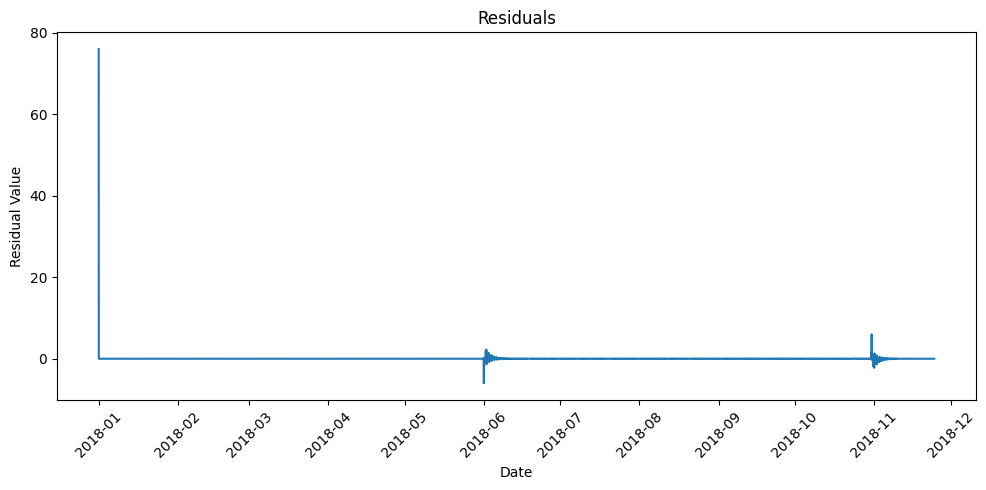

In [330]:
# Plot residuals
residuals = model_fit.resid
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title("Residuals")
plt.xlabel("Date")
plt.ylabel("Residual Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [331]:
# Predict
predictions = model_fit.get_forecast(steps=len(endog_test), exog=exog_test)
predicted_mean = predictions.predicted_mean
predicted_conf_int = predictions.conf_int()
lower_limits = predicted_conf_int.iloc[:, 0]
upper_limits = predicted_conf_int.iloc[:, 1]
predicted_mean = pd.Series(predicted_mean, index=endog_test.index)

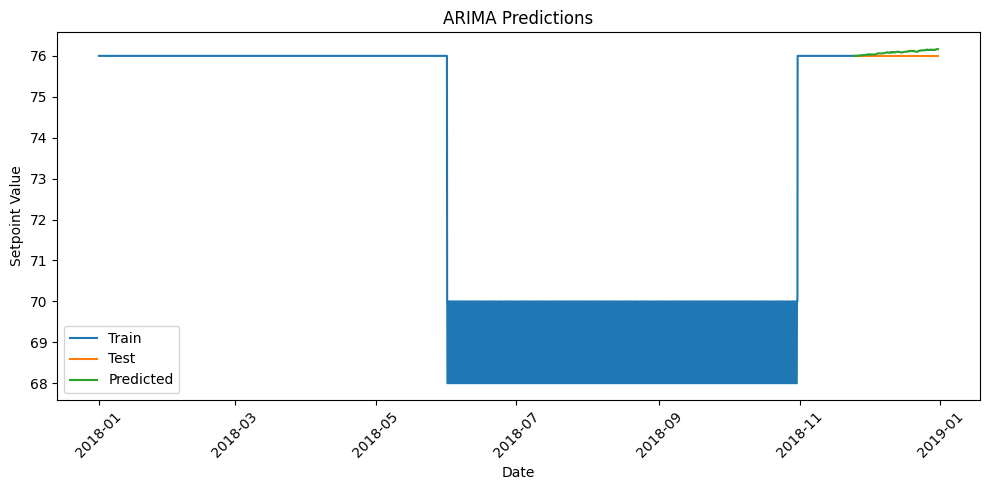

In [332]:
# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(endog_train.index, endog_train["setpoint"], label="Train")
plt.plot(endog_test.index, endog_test["setpoint"], label="Test")
plt.plot(predicted_mean.index, predicted_mean, label="Predicted")
plt.title("ARIMA Predictions")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## LSTM

In [293]:
train_data = pd.merge(
    endog_train,
    exog_train,
    left_index=True,
    right_index=True,
)

test_data = pd.merge(
    endog_test,
    exog_test,
    left_index=True,
    right_index=True,
)

In [294]:
# pass train_data and test_data to numpy
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()

In [295]:
# Hyperparameters
sequence_length = 24  # Number of past timesteps to look at
batch_size = 64

In [296]:
# Create sequences and labels
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length - 1):
        sequence = data[i:i+sequence_length]  # Get the sequence of past timesteps
        label = data[i+sequence_length, 0]    # Predict the setpoint (first feature)
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [297]:
train_sequences, train_labels = create_sequences(train_data, sequence_length)
test_sequences, test_labels = create_sequences(test_data, sequence_length)

In [298]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)


In [299]:
train_dataset = TimeSeriesDataset(train_sequences, train_labels)
test_dataset = TimeSeriesDataset(test_sequences, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [300]:
class LSTMSetpointPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(LSTMSetpointPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)  # Fully connected layer for the output

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # LSTM output
        lstm_out = lstm_out[:, -1, :]  # Take the output of the last time step
        out = self.fc(lstm_out)       # Pass through fully connected layer
        return out


In [301]:
# Model parameters
input_size = 3  # Setpoint, Weather, Heating_Energy_Consumption
hidden_size = 64
num_layers = 2
output_size = 1  # Predicting the setpoint
dropout = 0.7

In [302]:
# Instantiate the model
model = LSTMSetpointPredictor(input_size, hidden_size, num_layers, output_size, dropout)

In [303]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [304]:
# Training function
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for sequences, labels in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels.unsqueeze(1))  # Unsqueeze labels to match output dim
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')


In [305]:
# Train the model
num_epochs = 100
train(model, train_loader, criterion, optimizer, num_epochs)

Epoch 1/100, Loss: 4370.1194
Epoch 2/100, Loss: 3271.4206
Epoch 3/100, Loss: 2532.4579
Epoch 4/100, Loss: 1944.1969
Epoch 5/100, Loss: 1472.6748
Epoch 6/100, Loss: 1097.9290
Epoch 7/100, Loss: 804.3301
Epoch 8/100, Loss: 578.2809
Epoch 9/100, Loss: 407.6393
Epoch 10/100, Loss: 281.6986
Epoch 11/100, Loss: 191.1661
Epoch 12/100, Loss: 127.8438
Epoch 13/100, Loss: 84.7980
Epoch 14/100, Loss: 56.5325
Epoch 15/100, Loss: 38.5623
Epoch 16/100, Loss: 27.5646
Epoch 17/100, Loss: 21.0963
Epoch 18/100, Loss: 17.4542
Epoch 19/100, Loss: 15.4888
Epoch 20/100, Loss: 14.4733
Epoch 21/100, Loss: 13.9768
Epoch 22/100, Loss: 13.7452
Epoch 23/100, Loss: 13.6448
Epoch 24/100, Loss: 13.6031
Epoch 25/100, Loss: 13.5857
Epoch 26/100, Loss: 13.5796
Epoch 27/100, Loss: 13.5776
Epoch 28/100, Loss: 13.5759
Epoch 29/100, Loss: 13.5766
Epoch 30/100, Loss: 13.5763
Epoch 31/100, Loss: 13.5763
Epoch 32/100, Loss: 13.5775
Epoch 33/100, Loss: 13.5767
Epoch 34/100, Loss: 13.5767
Epoch 35/100, Loss: 13.5766
Epoch 36/10

In [306]:
def evaluate(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for sequences, labels in test_loader:
            outputs = model(sequences)
            predictions.append(outputs.numpy())
            actuals.append(labels.numpy())
    return np.concatenate(predictions), np.concatenate(actuals)


In [307]:
# Get predictions and actuals
predictions, actuals = evaluate(model, test_loader)

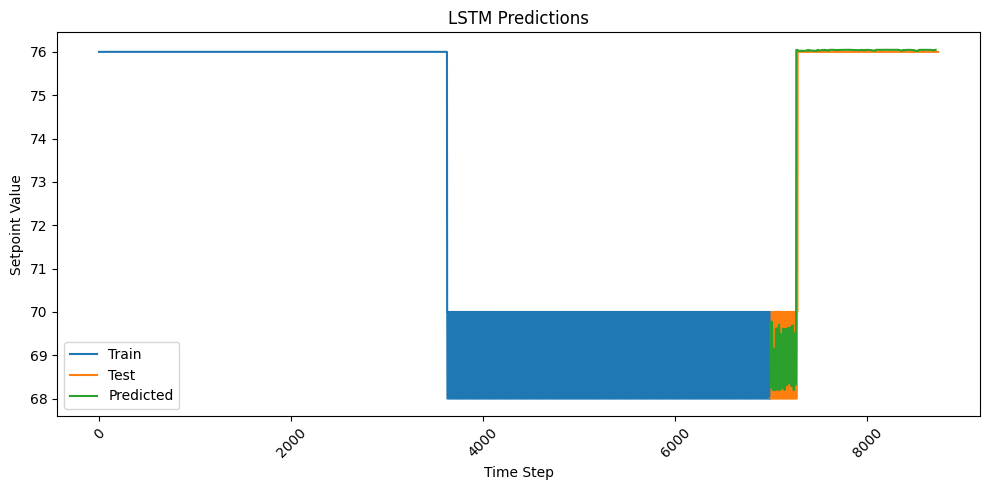

In [ ]:
# Plot train, test and predictions
plt.figure(figsize=(10, 5))
plt.plot(train_data[:, 0], label="Train")
plt.plot(np.arange(len(train_data), len(train_data) + len(test_data[:, 0])), test_data[:, 0], label="Test")
plt.plot(np.arange(len(train_data), len(train_data) + len(predictions)), predictions, label="Predicted")
plt.title("LSTM Predictions")
plt.xlabel("Time Step")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()